# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from __future__ import absolute_import, division, print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

# set default size of plots
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000,
                     num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing
    to prepare it for the linear classifier. These are the same
    steps as we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../data/cifar10'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return (X_train, y_train, X_val, y_val, X_test,
            y_test, X_dev, y_dev)


# Invoke the above function to get our data.
(X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev) = \
    get_CIFAR10_data()
print('Train data shape:', X_train.shape)
print('Train labels shape:', y_train.shape)
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)
print('dev data shape:', X_dev.shape)
print('dev labels shape:', y_dev.shape)

Train data shape: (49000, 3073)
Train labels shape: (49000,)
Validation data shape: (1000, 3073)
Validation labels shape: (1000,)
Test data shape: (1000, 3073)
Test labels shape: (1000,)
dev data shape: (500, 3073)
dev labels shape: (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
from cs231n.classifiers.softmax import softmax_loss_vectorized
import time

# Generate a random softmax weight matrix and use it to
# compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something
# close to -log(0.1).
print('loss: {:f}'.format(loss))
print('sanity check: {:f}'.format(-np.log(0.1)))

loss: 2.328601
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a
# (naive) version of the gradient that uses nested loops.
from cs231n.gradient_check import grad_check_sparse
softmax_loss = softmax_loss_naive # djn

# As we did for the SVM, use numeric gradient checking as a
# debugging tool. The numeric gradient should be close to the
# analytic gradient.
print('Gradient check WITHOUT regularization')
print('=====================================')
loss, grad = softmax_loss(W, X_dev, y_dev, 0.0)
f = lambda w: softmax_loss(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print('')

# similar to SVM case, do another gradient check with regularization
print('Gradient check WITH regularization')
print('==================================')
loss, grad = softmax_loss(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

Gradient check WITHOUT regularization
numerical: -0.582367 analytic: -0.582367, relative error: 4.159393e-08
numerical: 1.229813 analytic: 1.229813, relative error: 2.130453e-08
numerical: -2.491813 analytic: -2.491813, relative error: 1.927613e-09
numerical: -1.318178 analytic: -1.318178, relative error: 4.521022e-08
numerical: -0.101462 analytic: -0.101462, relative error: 2.110697e-07
numerical: -0.712589 analytic: -0.712589, relative error: 1.308271e-07
numerical: -0.284711 analytic: -0.284711, relative error: 7.008908e-08
numerical: 0.887626 analytic: 0.887626, relative error: 3.517009e-08
numerical: -5.002381 analytic: -5.002381, relative error: 1.352364e-09
numerical: 1.667349 analytic: 1.667349, relative error: 3.976806e-09

Gradient check WITH regularization
numerical: 0.618001 analytic: 0.618001, relative error: 8.156038e-08
numerical: -1.471470 analytic: -1.471470, relative error: 2.955383e-08
numerical: 0.733199 analytic: 0.733200, relative error: 7.406116e-08
numerical: -0

In [5]:
# Now that we have a naive implementation of the softmax loss
# function and its gradient, implement a vectorized version in
# softmax_loss_vectorized. The two versions should compute the
# same results, but the vectorized version should be much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: {:e} computed in {:f}s'.format(
    loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(
    W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: {:e} computed in {:f}s'.format(
    loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare
# the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized,
                                 ord='fro')
print('Loss difference:', np.abs(loss_naive - loss_vectorized))
print('Gradient difference:', grad_difference)

naive loss: 2.328601e+00 computed in 0.088101s
vectorized loss: 2.328601e+00 computed in 0.007384s
Loss difference: 8.881784197e-16
Gradient difference: 1.94377273183e-13


iteration 0/1500: loss 774.126390
iteration 100/1500: loss 283.518762
iteration 200/1500: loss 105.062199
iteration 300/1500: loss 39.779000
iteration 400/1500: loss 15.874299
iteration 500/1500: loss 7.181493
iteration 600/1500: loss 3.939793
iteration 700/1500: loss 2.804039
iteration 800/1500: loss 2.307532
iteration 900/1500: loss 2.195206
iteration 1000/1500: loss 2.108223
iteration 1100/1500: loss 2.080994
iteration 1200/1500: loss 2.089400
iteration 1300/1500: loss 2.062644
iteration 1400/1500: loss 2.084768
That took 6.376524s


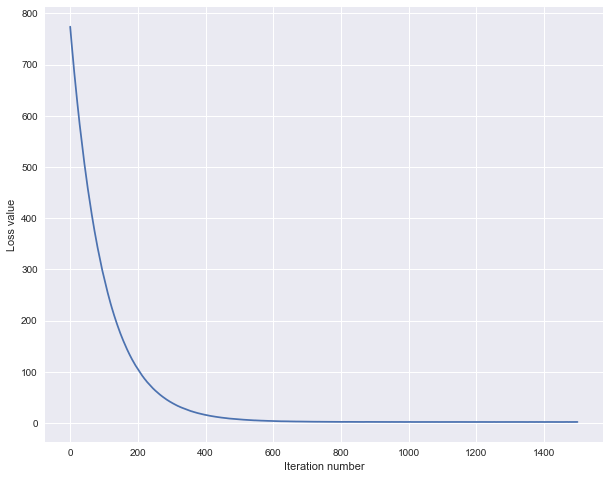

training accuracy: 0.326653
validation accuracy: 0.346000


In [6]:
## [djn] A practice run with softmax
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train,
                          learning_rate=1e-7, reg=5e4,
                          num_iters=1500, verbose=True)
toc = time.time()
print('That took {:f}s'.format(toc - tic))

# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

# Write the Softmax.predict function and evaluate the performance
# on both the training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: {:f}'.format(
    np.mean(y_train == y_train_pred)))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {:f}'.format(
    np.mean(y_val == y_val_pred)))

[1/25] (lr=1.74190897058e-06, reg=1700.31631056) val_acc=0.398
[2/25] (lr=1.74190897058e-06, reg=3465.84759027) val_acc=0.384
[3/25] (lr=1.74190897058e-06, reg=88549.5780497) val_acc=0.302
[4/25] (lr=1.74190897058e-06, reg=1919.30383354) val_acc=0.395
[5/25] (lr=1.74190897058e-06, reg=50580.9617812) val_acc=0.327
[6/25] (lr=3.16653068948e-07, reg=1700.31631056) val_acc=0.285
[7/25] (lr=3.16653068948e-07, reg=3465.84759027) val_acc=0.316
[8/25] (lr=3.16653068948e-07, reg=88549.5780497) val_acc=0.326
[9/25] (lr=3.16653068948e-07, reg=1919.30383354) val_acc=0.29
[10/25] (lr=3.16653068948e-07, reg=50580.9617812) val_acc=0.342
[11/25] (lr=3.66618146523e-07, reg=1700.31631056) val_acc=0.293
[12/25] (lr=3.66618146523e-07, reg=3465.84759027) val_acc=0.33
[13/25] (lr=3.66618146523e-07, reg=88549.5780497) val_acc=0.323
[14/25] (lr=3.66618146523e-07, reg=1919.30383354) val_acc=0.298
[15/25] (lr=3.66618146523e-07, reg=50580.9617812) val_acc=0.338
[16/25] (lr=9.92013473133e-07, reg=1700.31631056) v

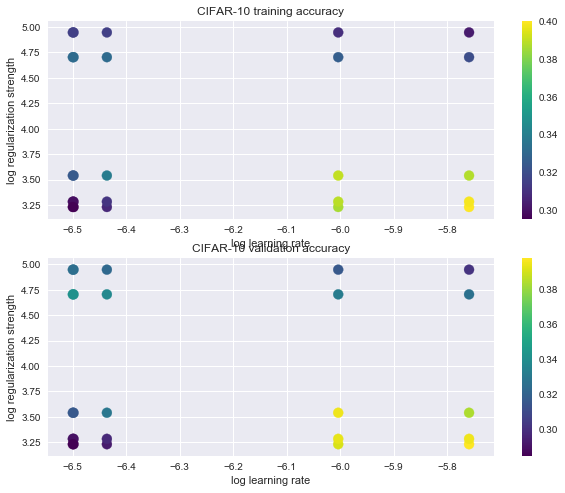

In [7]:
# Use the validation set to tune hyperparameters (regularization
# strength and learning rate). You should experiment with different
# ranges for the learning rates and regularization strengths;
# if you are careful you should be able to get a classification
# accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
num_iters = 600

#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [5e4, 1e8]


#learning_rates = 10 ** (0.5 * np.random.rand(10) - 6.5)
#regularization_strengths = 10 ** (0.8 * np.random.rand(10) + 2.5)

learning_rates =10 ** (np.random.rand(5) - 6.5)
regularization_strengths = 10 ** (2 * np.random.rand(5) + 3)

num_lr = len(learning_rates)
num_reg = len(regularization_strengths)
num_pts = num_lr * num_reg


####################################################################
# TODO:                                                            #
# Use the validation set to set the learning rate and              #
# regularization strength. This should be identical to the         #
# validation that you did for the SVM; save the best trained       #
# softmax classifer in best_softmax.                               #
####################################################################
import itertools

n_iters = 800
combinations = itertools.product(learning_rates,
                                 regularization_strengths)
count = 0
for lr, reg in combinations:
    np.random.seed(4023) # Keep W initialization invariant
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                  num_iters=n_iters)
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    train_accuracy = np.mean(y_train == y_train_pred)
    val_accuracy = np.mean(y_val == y_val_pred)
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_softmax = softmax
    count += 1
    print('[{}/{}] (lr={}, reg={}) val_acc={}'.format(
        count, num_pts, lr, reg, val_accuracy))

####################################################################
#                       END OF YOUR CODE                           #
####################################################################
    
# Print out results.
# for lr, reg in sorted(results):
#     train_accuracy, val_accuracy = results[(lr, reg)]
#     print('lr {:e} reg {:e} '
#           'train accuracy: {:f} val accuracy: {:f}'.format(
#               lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation:',
      best_val)

# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
cm = plt.cm.viridis #[djn] colormap
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size,
            c=colors, cmap=cm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] 
    # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size,
            c=colors, cmap=cm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [8]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy:',
      test_accuracy)

softmax on raw pixels final test set accuracy: 0.388


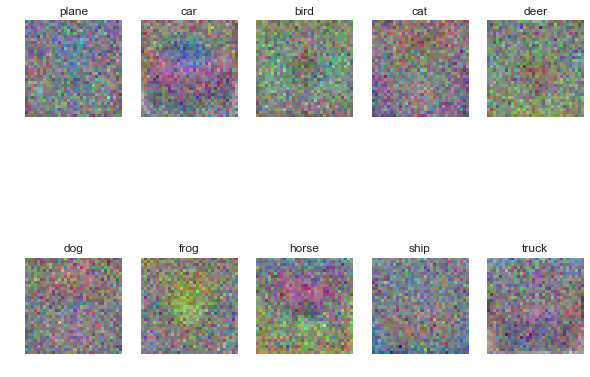

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) \
           / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])